In [1]:
%matplotlib inline

In [2]:
%load_ext blackcellmagic

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import sketch

In [4]:
PATH = ('/Users/kiralenz/Documents/keeprising/data/')

# Data

## Feeding data update

### Loading past feeding data

In [5]:
feedings = pd.read_parquet(PATH + 'feedings.parquet')

In [6]:
feedings_processed = pd.read_parquet(PATH + 'feedings_processed.parquet')

### Adding new data

In [7]:
date_today = '2022-12-20'

In [8]:
temperature_today = 19

In [9]:
feeding_time_today = 10

In [10]:
initial_height_today = 2.9

In [11]:
end_height_today = 7.9

In [12]:
bubble_size_today = 0.3

In [13]:
latest_feeding = pd.DataFrame(data={
    'feeding_date':date_today, 
    'temperature':temperature_today,
    'feeding_time':feeding_time_today,
    'initial_height':initial_height_today,
    'end_height':end_height_today,
    'bubble_size':bubble_size_today
}, index=[0])

### Df merging

In [14]:
feedings = pd.concat([feedings, latest_feeding], ignore_index=True)

In [15]:
feedings.to_parquet(PATH + 'feedings.parquet')

## Data processing

### Bacteria composition

**TODO**
* improve bacteria composition

In [16]:
bacteria_composition = pd.DataFrame({
    'temperature':[20, 25,30, 35],
    'dominant_microbes':['none', 'lactic acid bacteria', 'Acetic acid bacteria', 'sourdough yeast']
})

In [17]:
bacteria_composition

,temperature,dominant_microbes
0,20,none
1,25,lactic acid bacteria
2,30,Acetic acid bacteria
3,35,sourdough yeast


In [18]:
feedings["bacteria_composition"] = np.where(
    feedings["temperature"] <= 20,
    bacteria_composition.loc[
        bacteria_composition["temperature"] == 20, "dominant_microbes"
    ],
    np.where(
        ((feedings["temperature"] > 20) & (feedings["temperature"] <= 25)),
        bacteria_composition.loc[
            bacteria_composition["temperature"] == 25, "dominant_microbes"
        ],
        np.where(
            ((feedings["temperature"] > 25) & (feedings["temperature"] <= 30)),
            bacteria_composition.loc[
                bacteria_composition["temperature"] == 30, "dominant_microbes"
            ],
            bacteria_composition.loc[
                bacteria_composition["temperature"] == 35, "dominant_microbes"
            ],
        ),
    ),
)

### Growth rate

In [19]:
feedings['growth_rate'] = feedings['end_height'] / feedings['initial_height']

In [20]:
feedings['growth_rate_per_hour'] = feedings['end_height'] / feedings['initial_height'] / feedings['feeding_time']

In [21]:
feedings.head()

,feeding_date,temperature,feeding_time,initial_height,end_height,bubble_size,bacteria_composition,growth_rate,growth_rate_per_hour
0,2022-07-24,22,8,2.2,7.2,0.2,lactic acid bacteria,3.272727,0.409091
1,2022-07-31,22,7,2.4,7.8,0.4,lactic acid bacteria,3.250000,0.464286
2,2022-08-07,22,8,2.7,7.9,0.3,lactic acid bacteria,2.925926,0.365741
3,2022-08-14,22,8,2.1,6.3,0.2,lactic acid bacteria,3.000000,0.375000
4,2022-08-21,23,9,2.8,6.1,0.1,lactic acid bacteria,2.178571,0.242063


## Utilization

### Baked breads

#### Loading past bread data

In [22]:
baked_bread = pd.read_parquet(PATH + 'baked_bread.parquet')

#### Adding new data

In [23]:
latest_bread = 'Paderborner Landbrot'

In [24]:
latest_baking_date = '2022-12-14'

In [25]:
latest_ranking = 3

In [26]:
latest_starter_used = 30

In [27]:
latest_bread = pd.DataFrame(data={
    'bread_name':latest_bread,
    'baking_date':latest_baking_date,
    'bread_rating':latest_ranking,
    'used_starter':latest_starter_used
}, index=[0])

#### Df merging 

In [28]:
baked_bread = pd.concat([baked_bread, latest_bread], ignore_index=True)

In [29]:
baked_bread['baking_date'] = pd.to_datetime(baked_bread['baking_date'])

In [30]:
baked_bread.to_parquet(PATH + 'baked_bread.parquet')

### Utilized sourdough starter

#### For baking

In [31]:
used_for_bread = baked_bread[['baking_date', 'used_starter']]

In [32]:
used_for_bread.rename(columns={
    'baking_date':'date',
    'used_starter':'delta_starter'
}, inplace=True)

/var/folders/6b/lt0s1m814q78c4z0v8ddb_p40000gn/T/ipykernel_1316/4108514966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  used_for_bread.rename(columns={


In [33]:
used_for_bread['delta_starter'] = used_for_bread['delta_starter']*(-1)

/var/folders/6b/lt0s1m814q78c4z0v8ddb_p40000gn/T/ipykernel_1316/924016032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  used_for_bread['delta_starter'] = used_for_bread['delta_starter']*(-1)


In [34]:
used_for_bread

,date,delta_starter
0,2022-08-13,-10.0
1,2022-09-18,-20.0
2,2022-10-23,-15.0
3,2022-11-01,-10.0
4,2023-03-26,-10.0
5,2022-12-14,-30.0
6,2023-03-29,-0.0
7,2023-03-29,-0.0
8,2023-03-30,-0.0
9,2023-03-30,-0.0


#### Leftover from feeding

In [35]:
old_dough = feedings[['feeding_date']]

In [36]:
old_dough.rename(columns={'feeding_date':'date'}, inplace=True)

/var/folders/6b/lt0s1m814q78c4z0v8ddb_p40000gn/T/ipykernel_1316/1372661557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_dough.rename(columns={'feeding_date':'date'}, inplace=True)


In [37]:
# assuming a use of 10g for the new starter and a loss of 10g
old_dough['delta_starter'] = 90

/var/folders/6b/lt0s1m814q78c4z0v8ddb_p40000gn/T/ipykernel_1316/680216621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_dough['delta_starter'] = 90


#### Recycle utilizations

In [39]:
recyled_dough = pd.read_parquet(PATH + 'recycled_dough.parquet')

In [41]:
recyled_dough

,date,recycling_happened
0,2022-09-13,True
1,2022-10-18,True
2,2022-11-23,True
3,2022-12-01,True


#### Total

In [40]:
left_over = pd.concat([used_for_bread, old_dough, recyled_dough], ignore_index=True)

In [40]:
left_over['date'] = pd.to_datetime(left_over['date'])

In [41]:
left_over.sort_values(by='date', inplace=True)

In [42]:
left_over['recycling_happened'] = left_over['recycling_happened'].fillna(False)

In [43]:
left_over.reset_index(inplace=True, drop=True)

In [44]:
total_dough = []
cumsum = 0
for index, row in left_over.iterrows():
    if row['recycling_happened'] == False:
        cumsum = cumsum + row['delta_starter'] 
        total_dough.append(cumsum)
    else:
        cumsum = 0
        total_dough.append(cumsum)

In [45]:
left_over['total_dough'] = total_dough

### Bread experiments TODO

**TODO**
* Vorgehen + Modifikation + Resultat + Experimentbasis (Brot) 

# KPIs

## Bread

**Top 3 breads**

In [46]:
baked_bread.sort_values(by='bread_rating', ascending=False)['bread_name'].head(3)

1    Italienisches Landbrot
3                   Neptune
0               Dinkelsonni
Name: bread_name, dtype: object

**Baked breads**

In [47]:
len(baked_bread)

11

**Relevant factors**

## Sourdough

**Current bacteria dominance**

In [48]:
feedings['bacteria_composition'].tail(1)

22    none
Name: bacteria_composition, dtype: object

## Leftovers

**TODO**
* turn into function

In [49]:
if left_over.iloc[-1, 1] > 200:
    print('Time to get creative! You have ' + str(left_over.iloc[-1, 1]) + 'g of starter leftover.')
else:
    print('You have ' + str(left_over.iloc[-1, 1]) + 'g of starter leftover.')

You have -0.0g of starter leftover.


# Plots

## Bread

In [50]:
plot_baked_bread = baked_bread.groupby(pd.Grouper(key="baking_date", freq="M"))[
        "bread_rating"
    ].mean().to_frame('avg_bread_rating')

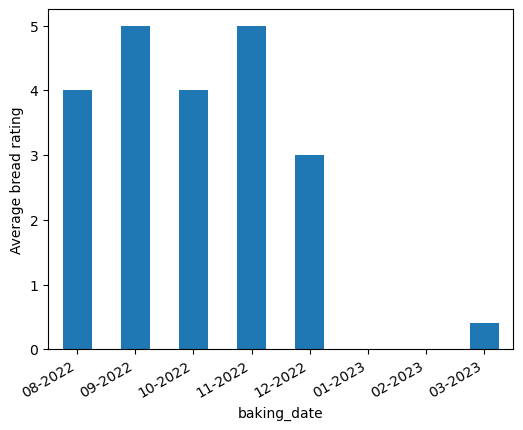

In [51]:
fig, ax = plt.subplots(figsize=(6, 5))

plot_baked_bread.plot(kind='bar', ylabel='Average bread rating', legend=False, ax=ax)

# Adapt the x tick labels
ticklabels = plot_baked_bread.index
ticklabels = [item.strftime('%m-%Y') for item in plot_baked_bread.index]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()

plt.show()

## Feeding

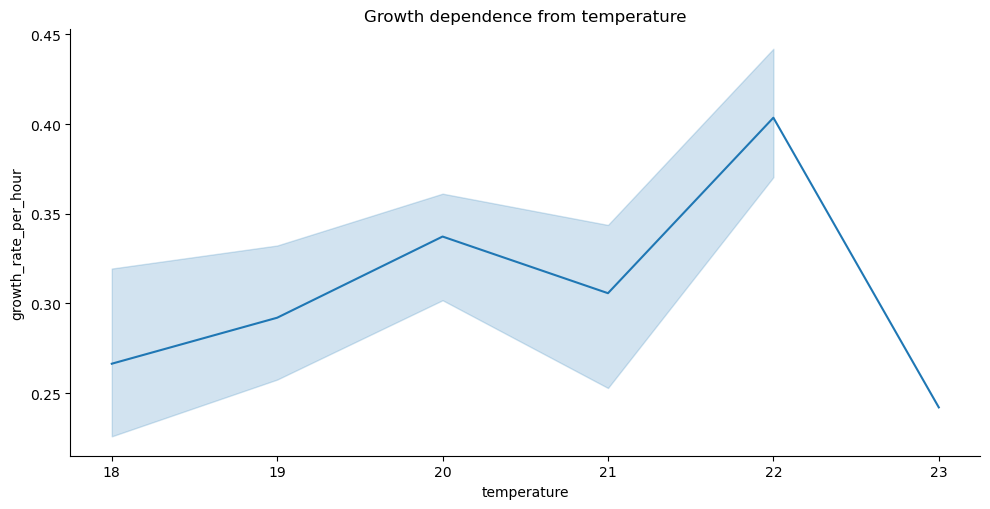

In [52]:
sns.relplot(data=feedings, x="temperature", y="growth_rate_per_hour", kind="line", height=5, aspect=2).set(
    title="Growth dependence from temperature"
);

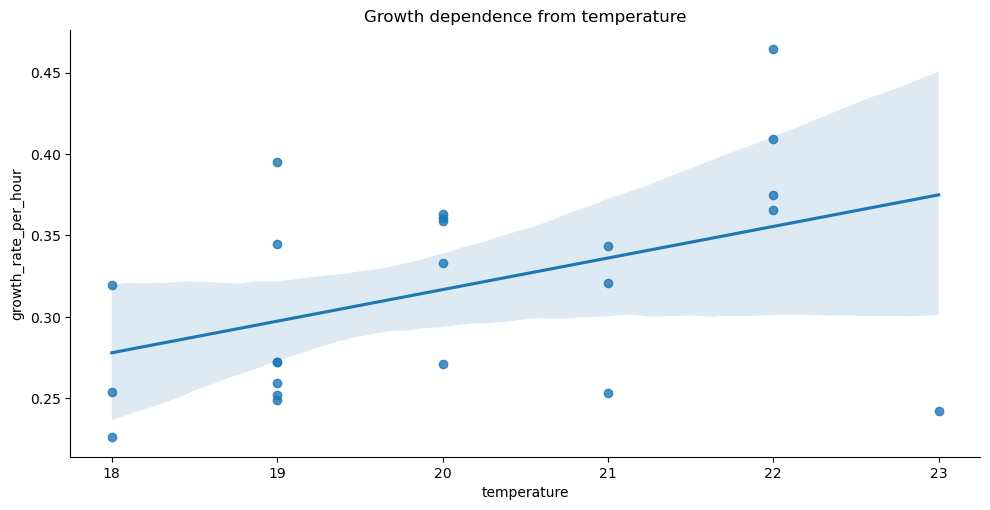

In [53]:
sns.lmplot(data=feedings, x='temperature', y='growth_rate_per_hour', height=5, aspect=2).set(
    title="Growth dependence from temperature"
);

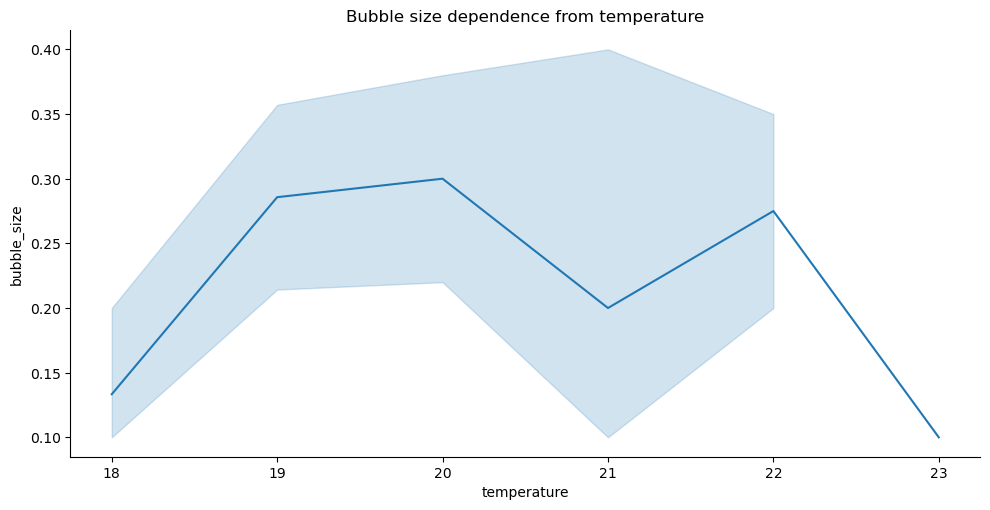

In [54]:
sns.relplot(data=feedings, x='temperature', y='bubble_size', kind='line',  height=5, aspect=2).set(
    title="Bubble size dependence from temperature"
);

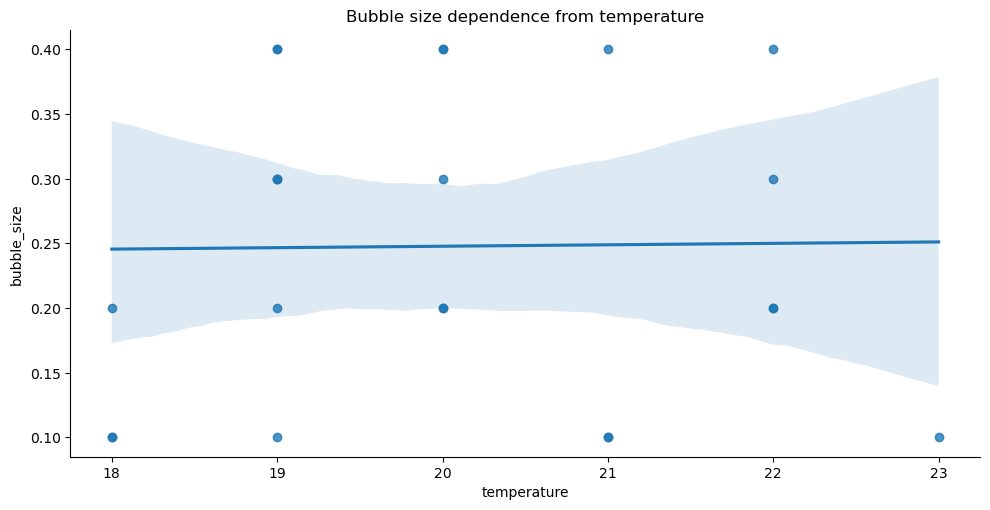

In [55]:
sns.lmplot(data=feedings, x='temperature', y='bubble_size', height=5, aspect=2).set(
    title="Bubble size dependence from temperature"
);

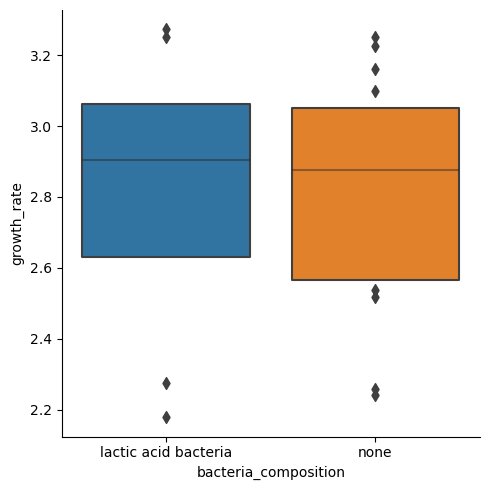

In [56]:
sns.catplot(data=feedings, x='bacteria_composition', y='growth_rate', kind='boxen');

In [57]:
import seaborn as sns

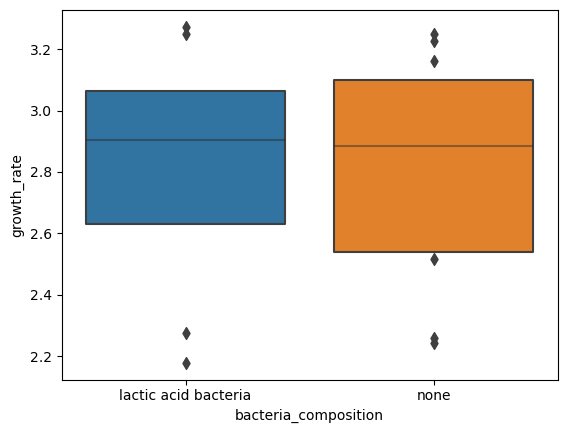

In [58]:
bacteria_composition = sns.boxenplot(x="bacteria_composition", y="growth_rate", data=feedings_processed) #.set(title="Growth Rate by Bacteria Composition")